In [1]:
import sys
from envs import ENVS_DICTIONARY

sys.path.append('../baselines/baselines/')

import deepq

[2017-11-21 02:11:11,189] Making new env: MountainCar-v0
[2017-11-21 02:11:11,206] Making new env: CartPole-v1


In [2]:
env = ENVS_DICTIONARY['3DMountainCar']()

In [3]:
import os
import tempfile

import tensorflow as tf
import zipfile
import cloudpickle
import numpy as np

import gym
import baselines.common.tf_util as U
from baselines import logger
from baselines.common.schedules import LinearSchedule
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

In [4]:
"""
*Copied from OpenAI Baselines deeq implementation
https://github.com/TransferRL/baselines/blob/master/baselines/deepq/simple.py
"""

class ActWrapper(object):
    def __init__(self, act, act_params):
        self._act = act
        self._act_params = act_params

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            model_data, act_params = cloudpickle.load(f)
        act = deepq.build_act(**act_params)
        sess = tf.Session()
        sess.__enter__()
        with tempfile.TemporaryDirectory() as td:
            arc_path = os.path.join(td, "packed.zip")
            with open(arc_path, "wb") as f:
                f.write(model_data)

            zipfile.ZipFile(arc_path, 'r', zipfile.ZIP_DEFLATED).extractall(td)
            U.load_state(os.path.join(td, "model"))

        return ActWrapper(act, act_params)

    def __call__(self, *args, **kwargs):
        return self._act(*args, **kwargs)

    def save(self, path=None):
        """Save model to a pickle located at `path`"""
        if path is None:
            path = os.path.join(logger.get_dir(), "model.pkl")

        with tempfile.TemporaryDirectory() as td:
            U.save_state(os.path.join(td, "model"))
            arc_name = os.path.join(td, "packed.zip")
            with zipfile.ZipFile(arc_name, 'w') as zipf:
                for root, dirs, files in os.walk(td):
                    for fname in files:
                        file_path = os.path.join(root, fname)
                        if file_path != arc_name:
                            zipf.write(file_path, os.path.relpath(file_path, td))
            with open(arc_name, "rb") as f:
                model_data = f.read()
        with open(path, "wb") as f:
            cloudpickle.dump((model_data, self._act_params), f)

In [5]:
"""
*All code below copied and MODIFIED from OpenAI Baselines deeq implementation
https://github.com/TransferRL/baselines/blob/master/baselines/deepq/simple.py
"""


class DeepQ(object):
    """Train a deepq model.

    Parameters
    -------
    env: gym.Env
        environment to train on
    q_func: (tf.Variable, int, str, bool) -> tf.Variable
        the model that takes the following inputs:
            observation_in: object
                the output of observation placeholder
            num_actions: int
                number of actions
            scope: str
            reuse: bool
                should be passed to outer variable scope
        and returns a tensor of shape (batch_size, num_actions) with values of every action.
    lr: float
        learning rate for adam optimizer
    max_timesteps: int
        number of env steps to optimizer for
    buffer_size: int
        size of the replay buffer
    exploration_fraction: float
        fraction of entire training period over which the exploration rate is annealed
    exploration_final_eps: float
        final value of random action probability
    train_freq: int
        update the model every `train_freq` steps.
        set to None to disable printing
    batch_size: int
        size of a batched sampled from replay buffer for training
    print_freq: int
        how often to print out training progress
        set to None to disable printing
    checkpoint_freq: int
        how often to save the model. This is so that the best version is restored
        at the end of the training. If you do not wish to restore the best version at
        the end of the training set this variable to None.
    learning_starts: int
        how many steps of the model to collect transitions for before learning starts
    gamma: float
        discount factor
    target_network_update_freq: int
        update the target network every `target_network_update_freq` steps.
    prioritized_replay: True
        if True prioritized replay buffer will be used.
    prioritized_replay_alpha: float
        alpha parameter for prioritized replay buffer
    prioritized_replay_beta0: float
        initial value of beta for prioritized replay buffer
    prioritized_replay_beta_iters: int
        number of iterations over which beta will be annealed from initial value
        to 1.0. If set to None equals to max_timesteps.
    prioritized_replay_eps: float
        epsilon to add to the TD errors when updating priorities.
    callback: (locals, globals) -> None
        function called at every steps with state of the algorithm.
        If callback returns true training stops.

    Returns
    -------
    act: ActWrapper
        Wrapper over act function. Adds ability to save it and load it.
        See header of baselines/deepq/categorical.py for details on the act function.
    """
    
    
    def __init__(self,
              env,
              q_func,
              lr=5e-4,
              max_timesteps=100000,
              buffer_size=50000,
              exploration_fraction=0.1,
              exploration_final_eps=0.02,
              train_freq=1,
              batch_size=32,
              print_freq=100,
              checkpoint_freq=10000,
              learning_starts=1000,
              gamma=1.0,
              target_network_update_freq=500,
              prioritized_replay=False,
              prioritized_replay_alpha=0.6,
              prioritized_replay_beta0=0.4,
              prioritized_replay_beta_iters=None,
              prioritized_replay_eps=1e-6,
              param_noise=False,
              callback=None):

        self.env = env
        self.q_func=q_func
        self.lr=lr
        self.max_timesteps=max_timesteps
        self.buffer_size=buffer_size
        self.exploration_fraction=exploration_fraction
        self.exploration_final_eps=exploration_final_eps
        self.train_freq=train_freq
        self.batch_size=batch_size
        self.print_freq=print_freq
        self.checkpoint_freq=checkpoint_freq
        self.learning_starts=learning_starts
        self.gamma=gamma
        self.target_network_update_freq=target_network_update_freq
        self.prioritized_replay=prioritized_replay
        self.prioritized_replay_alpha=prioritized_replay_alpha
        self.prioritized_replay_beta0=prioritized_replay_beta0
        self.prioritized_replay_beta_iters=prioritized_replay_beta_iters
        self.prioritized_replay_eps=prioritized_replay_eps
        self.param_noise=param_noise
        self.callback=callback
    
        # Create all the functions necessary to train the model

        self.sess = tf.Session()
        self.sess.__enter__()

        # capture the shape outside the closure so that the env object is not serialized
        # by cloudpickle when serializing make_obs_ph
        self.observation_space_shape = env.observation_space.shape
    
    def make_obs_ph(self,name):
        return U.BatchInput(self.observation_space_shape, name=name)

    def make_build_train(self):
        # Build act and train networks
        self.act, self.train, self.update_target, self.debug = deepq.build_train(
            make_obs_ph=self.make_obs_ph,
            q_func=self.q_func,
            num_actions=self.env.action_space.n,
            optimizer=tf.train.AdamOptimizer(learning_rate=self.lr),
            gamma=self.gamma,
            grad_norm_clipping=10,
            param_noise=self.param_noise
        )

        self.act_params = {
            'make_obs_ph': self.make_obs_ph,
            'q_func': self.q_func,
            'num_actions': self.env.action_space.n,
        }

        self.act = ActWrapper(self.act, self.act_params)
        
        return 'make_build_train() complete'
        
    def initialize(self):
        # Create the replay buffer
        if self.prioritized_replay:
            self.replay_buffer = PrioritizedReplayBuffer(self.buffer_size, alpha=self.prioritized_replay_alpha)
            if self.prioritized_replay_beta_iters is None:
                self.prioritized_replay_beta_iters = self.max_timesteps
            self.beta_schedule = LinearSchedule(self.prioritized_replay_beta_iters,
                                           initial_p=self.prioritized_replay_beta0,
                                           final_p=1.0)
        else:
            self.replay_buffer = ReplayBuffer(self.buffer_size)
            self.beta_schedule = None
        # Create the schedule for exploration starting from 1.
        self.exploration = LinearSchedule(schedule_timesteps=int(self.exploration_fraction * self.max_timesteps),
                                     initial_p=1.0,
                                     final_p=self.exploration_final_eps)

        # Initialize the parameters and copy them to the target network.
        U.initialize()
        self.update_target()
        
        return 'initialize() complete'
    
    def transfer_pretrain(self, 
                          transferred_instances
                         ,epochs
                         ,tr_batch_size
                         ,keep_in_replay_buffer=True
                         ):
        """
        This is a custom function from University of Toronto group to first pretrain
        the deepq train network with transferred instances. These instances must be
        zip([s],[a],[r],[s']) tuples mapped over to the same state and action spaces as the target
        task environment.
        
        No output - just updates parameters of train and target networks.
        """
        # TODO - function that trains self.act and self.train using mapped instances
        done = False
        # pack all instances into replay buffer
        for obs, action, rew, new_obs in transferred_instances:            
            self.replay_buffer.add(obs, action, rew, new_obs, float(done))
        
        for epoch in range(epochs):
            obses_t, actions, rewards, obses_tp1, dones = self.replay_buffer.sample(tr_batch_size)
            weights, batch_idxes = np.ones_like(rewards), None
            td_errors = self.train(obses_t, actions, rewards, obses_tp1, dones, weights)
            
        self.update_target()
        
        if keep_in_replay_buffer is not True:
            self.replay_buffer = ReplayBuffer(self.buffer_size)
        
        return 'transfer_pretrain() complete'

    
    def task_train(self):
        self.episode_rewards = [0.0]
        self.episode_steps = [0.0]
        self.saved_mean_reward = None
        obs = self.env.reset()
        reset = True
        with tempfile.TemporaryDirectory() as td:
            model_saved = False
            model_file = os.path.join(td, "model")
            for t in range(self.max_timesteps):
                if self.callback is not None:
                    if self.callback(locals(), globals()):
                        break
                # Take action and update exploration to the newest value
                kwargs = {}
                if not self.param_noise:
                    update_eps = self.exploration.value(t)
                    update_param_noise_threshold = 0.
                else:
                    update_eps = 0.
                    # Compute the threshold such that the KL divergence between perturbed and non-perturbed
                    # policy is comparable to eps-greedy exploration with eps = exploration.value(t).
                    # See Appendix C.1 in Parameter Space Noise for Exploration, Plappert et al., 2017
                    # for detailed explanation.
                    update_param_noise_threshold = -np.log(1. - self.exploration.value(t) + self.exploration.value(t) / float(self.env.action_space.n))
                    kwargs['reset'] = reset
                    kwargs['update_param_noise_threshold'] = update_param_noise_threshold
                    kwargs['update_param_noise_scale'] = True
                action = self.act(np.array(obs)[None], update_eps=update_eps, **kwargs)[0]
                env_action = action
                reset = False
                new_obs, rew, done, _ = self.env.step(env_action)
                # Store transition in the replay buffer.
                self.replay_buffer.add(obs, action, rew, new_obs, float(done))
                obs = new_obs

                self.episode_rewards[-1] += rew
                self.episode_steps[-1] += 1
                if done:
                    obs = self.env.reset()
                    self.episode_rewards.append(0.0)
                    self.episode_steps.append(0.0)
                    reset = True

                if t > self.learning_starts and t % self.train_freq == 0:
                    # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                    if self.prioritized_replay:
                        experience = self.replay_buffer.sample(self.batch_size, beta=self.beta_schedule.value(t))
                        (obses_t, actions, rewards, obses_tp1, dones, weights, batch_idxes) = experience
                    else:
                        obses_t, actions, rewards, obses_tp1, dones = self.replay_buffer.sample(self.batch_size)
                        weights, batch_idxes = np.ones_like(rewards), None
                    td_errors = self.train(obses_t, actions, rewards, obses_tp1, dones, weights)
                    if self.prioritized_replay:
                        new_priorities = np.abs(td_errors) + self.prioritized_replay_eps
                        self.replay_buffer.update_priorities(batch_idxes, new_priorities)

                if t > self.learning_starts and t % self.target_network_update_freq == 0:
                    # Update target network periodically.
                    self.update_target()

                mean_100ep_reward = round(np.mean(self.episode_rewards[-101:-1]), 1)
                num_episodes = len(self.episode_rewards)
                if done and self.print_freq is not None and len(self.episode_rewards) % self.print_freq == 0:
                    logger.record_tabular("steps", t)
                    logger.record_tabular("episodes", num_episodes)
                    logger.record_tabular("mean 100 episode reward", mean_100ep_reward)
                    logger.record_tabular("% time spent exploring", int(100 * self.exploration.value(t)))
                    logger.dump_tabular()

                if (self.checkpoint_freq is not None and t > self.learning_starts and
                        num_episodes > 100 and t % self.checkpoint_freq == 0):
                    if self.saved_mean_reward is None or mean_100ep_reward > self.saved_mean_reward:
                        if self.print_freq is not None:
                            logger.log("Saving model due to mean reward increase: {} -> {}".format(
                                       self.saved_mean_reward, mean_100ep_reward))
                        U.save_state(model_file)
                        model_saved = True
                        self.saved_mean_reward = mean_100ep_reward
            if model_saved:
                if self.print_freq is not None:
                    logger.log("Restored model with mean reward: {}".format(self.saved_mean_reward))
                U.load_state(model_file)

        return self.act, self.episode_rewards, self.episode_steps


In [6]:


model = deepq.models.mlp([64], layer_norm=True)
dq = DeepQ(
        env,
        q_func=model,
        lr=1e-3,
        max_timesteps=10000,
        buffer_size=50000,
        exploration_fraction=0.1,
        exploration_final_eps=0.1,
        print_freq=10,
        param_noise=True)

In [7]:
dq.make_build_train()

'make_build_train() complete'

In [8]:
dq.initialize()

'initialize() complete'

In [10]:
dq.transfer_pretrain(zip([[0,0,0,0],[0,0,0,0]],[2,3],[-1,-1],[[0,0,0,0],[0,0,0,0]])
                         ,epochs = 100
                         ,tr_batch_size = 32
                         ,keep_in_replay_buffer=True
                         )

'transfer_pretrain() complete'

In [9]:
act, episode_rewards, episode_steps = dq.task_train()

//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

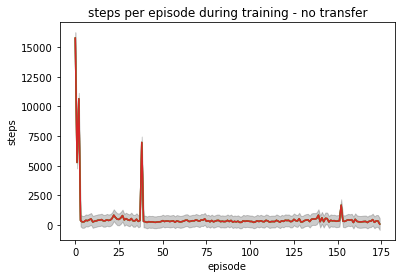

In [21]:
from matplotlib import pyplot as plt
plt.plot(range(len(episode_steps)),episode_steps)
plt.fill_between(range(len(episode_steps)),np.array(episode_steps) - 500,np.array(episode_steps) + 500, alpha=0.2, color='k')
plt.title('steps per episode during training - no transfer')
plt.xlabel('episode')
plt.ylabel('steps')
plt.show()

In [14]:
episode_steps[-50:]

[468.0,
 362.0,
 330.0,
 523.0,
 247.0,
 268.0,
 362.0,
 413.0,
 433.0,
 283.0,
 469.0,
 502.0,
 490.0,
 550.0,
 819.0,
 277.0,
 600.0,
 274.0,
 552.0,
 534.0,
 248.0,
 390.0,
 342.0,
 361.0,
 306.0,
 321.0,
 356.0,
 1666.0,
 325.0,
 294.0,
 370.0,
 433.0,
 395.0,
 442.0,
 200.0,
 475.0,
 302.0,
 266.0,
 250.0,
 271.0,
 285.0,
 292.0,
 204.0,
 304.0,
 317.0,
 449.0,
 218.0,
 335.0,
 335.0,
 77.0]

In [9]:
experiments = []
for _ in range(3):
    # use transferred tuples to learn initial target policy \pi_{T}^{o}
    dq.initialize()

    # use initial target policy and learn as we go
    act, episode_rewards, episode_steps = dq.task_train()
    experiments.append((episode_rewards,episode_steps))

//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
experiments

[([-1619.0, -686.0, -417.0, -715.0, -1319.0, -1231.0, -980.0, -3033.0],
  [1619.0, 686.0, 417.0, 715.0, 1319.0, 1231.0, 980.0, 3033.0]),
 ([-2160.0, -2605.0, -741.0, -4494.0], [2160.0, 2605.0, 741.0, 4494.0]),
 ([-296.0, -7867.0, -524.0, -430.0, -316.0, -420.0, -147.0],
  [296.0, 7867.0, 524.0, 430.0, 316.0, 420.0, 147.0])]

In [35]:
def plot_with_gp(X,y,title='',xlabel='',ylabel=''):
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X, y)
    X_ = np.linspace(min(X), max(X), 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                         alpha=0.2, color='k')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [36]:
X, rewards, steps = [], [], []
for episode_rewards, episode_steps in experiments:
    X += [i for i in range(len(episode_steps))]
    rewards += episode_rewards
    steps += episode_steps
    
X = np.array(X).reshape(-1,1)

//anaconda/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


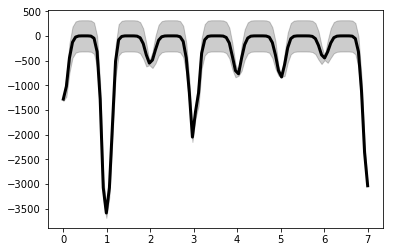

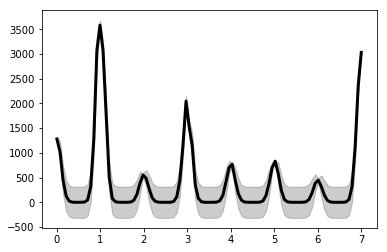

In [49]:
plot_with_gp(X,rewards,title='',xlabel='',ylabel='')

plot_with_gp(X,steps,title='',xlabel='',ylabel='')

In [22]:
from matplotlib import pyplot as plt

In [17]:
len(rewards)

19

In [48]:
experiments[0][0][3]

-715.0

In [50]:
dq2 = DeepQ(
        env,
        q_func=model,
        lr=1e-3,
        max_timesteps=10000,
        buffer_size=50000,
        exploration_fraction=0.1,
        exploration_final_eps=0.1,
        print_freq=10,
        param_noise=True)

In [51]:
dq2.make_build_train()

ValueError: Variable deepq/eps already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/Users/dangoldberg/openai_gym/baselines/baselines/deepq/build_graph.py", line 213, in build_act_with_param_noise
    eps = tf.get_variable("eps", (), initializer=tf.constant_initializer(0))
  File "/Users/dangoldberg/openai_gym/baselines/baselines/deepq/build_graph.py", line 339, in build_train
    param_noise_filter_func=param_noise_filter_func)
  File "<ipython-input-5-a05a4822a451>", line 141, in make_build_train
    param_noise=self.param_noise


In [53]:
a = np.array([[1,2,3]])
a.shape

(1, 3)

In [55]:
a.squeeze().shape

(3,)

[2017-11-21 03:13:35,391] Making new env: MountainCar-v0
[2017-11-21 03:13:35,410] Making new env: CartPole-v1
squared reconstruction average batch error: 72.3034865234375: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


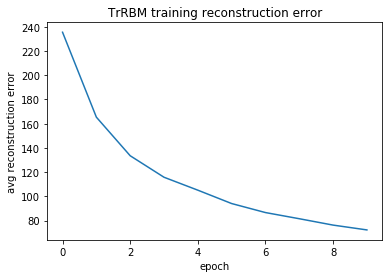

DEBUG: mapping instances over using TrRBM
DEBUG: preparing target instances
DEBUG: generating black-box rewards


ValueError: Cannot feed value of shape (32, 1) for Tensor 'deepq_1/reward:0', which has shape '(?,)'

In [1]:
%run TrRBM_2d_3d.py

In [ ]:
%debug

> //anaconda/lib/python3.5/site-packages/tensorflow/python/client/session.py(961)_run()
    959                 'Cannot feed value of shape %r for Tensor %r, '
    960                 'which has shape %r'
--> 961                 % (np_val.shape, subfeed_t.name, str(subfeed_t.get_shape())))
    962           if not self.graph.is_feedable(subfeed_t):
    963             raise ValueError('Tensor %s may not be fed.' % subfeed_t)

ipdb> up
> //anaconda/lib/python3.5/site-packages/tensorflow/python/client/session.py(785)run()
    783       tf_session.TF_DeleteBuffer(run_metadata_ptr)
    784       if options:
--> 785         tf_session.TF_DeleteBuffer(options_ptr)
    786     return result
    787 

ipdb> up
> /Users/dangoldberg/openai_gym/baselines/baselines/common/tf_util.py(445)__call__()
    443         for inpt in self.givens:
    444             feed_dict[inpt] = feed_dict.get(inpt, self.givens[inpt])
--> 445         results = get_session().run(self.outputs_update, feed_dict=feed_dict)